In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from torch.distributions import Normal
from utils.losses.elbo_ard_reg import elbo
from utils.fit import MeanFieldParams, FullRankParams, train_advi
from sklearn.model_selection import train_test_split

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

tensor([-0.3301,  0.0000,  0.0000,  0.4544, -1.4577,  0.0000, -0.6620, -2.8476,
         0.9155,  0.0000,  5.1494,  0.0000,  0.0000, -1.9888,  0.0000,  0.0000,
         0.0000,  0.0000, -0.2078, -2.3674,  0.0000,  0.0000, -5.1409, -0.2901,
        -3.7635,  0.0000,  0.7288,  0.6079,  0.5534,  2.1956,  3.4449,  0.0000,
        -2.5576,  0.0000,  0.0000, -3.2508,  0.0000,  3.7033,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -1.6586,  0.0000,  0.2762, -0.6630,
        -3.9242, -1.4353, -0.0580,  0.0000,  2.2311, -2.1699,  0.5440,  0.0000,
         0.0000, -0.0158,  0.2535,  3.9485,  0.0000, -0.3834,  1.0139,  0.0000,
        -2.5856, -0.3132,  0.0000,  0.0000,  0.0000, -1.6180, -0.5915,  0.0000,
         1.0506,  0.0000,  0.0000,  1.8374,  0.0000, -1.6479,  1.3662,  0.0000,
         0.3191,  0.0000,  1.1696, -0.8329,  0.0000, -0.4496, -0.3164,  1.1009,
         1.2217,  0.0000,  0.0000, -3.2215,  0.6400,  1.1376, -0.8848,  2.1821,
         0.9363, -1.4187,  2.3924,  0.00

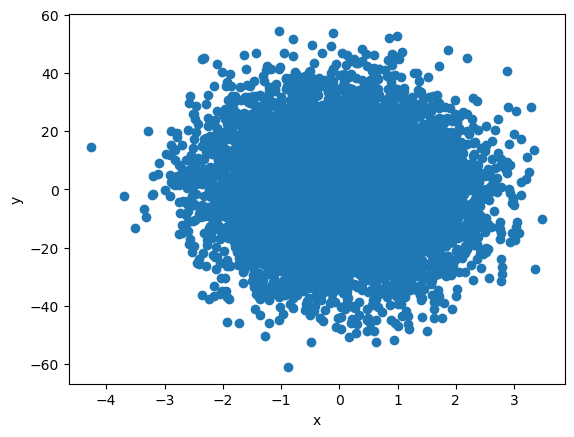

In [2]:
# Generate data
N = 11000
k = 100

# beta = np.array([0.1, -2.0])
sigma = 0.1
beta = Normal(0, 2).sample((k, ))
ind = np.random.choice(k, int(0.5*k))
beta[ind] = 0
x = torch.randn(N, k) 
y = Normal(x@beta, sigma).rsample()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=10000)

# Plot data
print(beta)
plt.scatter(x[:, 0].numpy(), y.numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
# x_train, x_val, y_train, y_val = train_test_split(x, y)

In [4]:
advi_mode = "fullrank"
advi_mode = "meanfield"

if advi_mode == "fullrank":
    model_params = {"params": FullRankParams(size=201)}
elif advi_mode == "meanfield":
    model_params = {
        'beta': MeanFieldParams(size=k), 
        "sig": MeanFieldParams(size=1),
        "alpha": MeanFieldParams(size=k),
    }

elbo_hist = []
logpred_hist = []

In [11]:
elbo_hist, logpred_hist = train_advi(
    x_train, y_train, x_val, y_val, 
    model_params, elbo_reg,
    full_data_size=10000,
    max_iter=1000,
    batch_size=200,
    lr=.001,
    advi_mode=advi_mode,
    schedule_model="min",
    elbo_hist=elbo_hist,
    logpred_hist=logpred_hist,
)

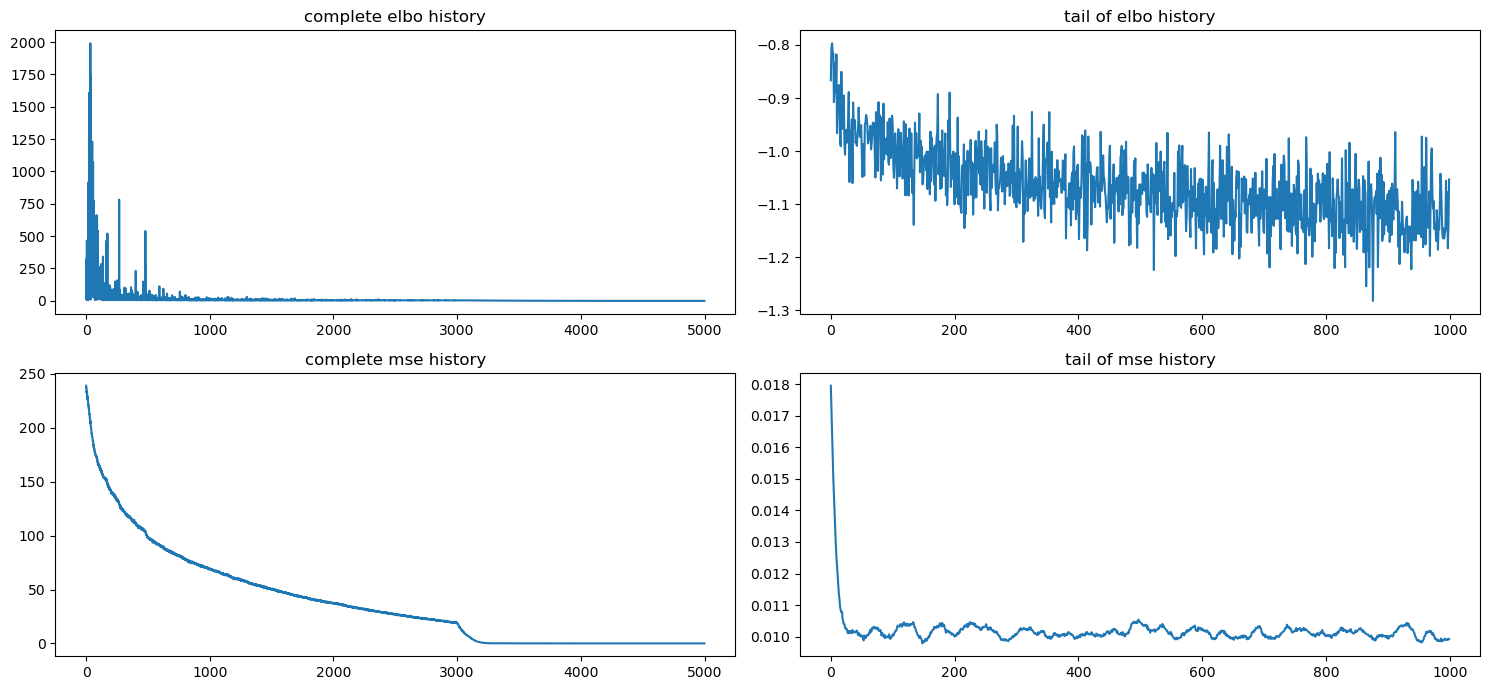

In [12]:
# Plot ELBO history
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(15, 7))

axes[0, 0].plot(elbo_hist)
axes[0, 0].set_title('complete elbo history')

# Plot ELBO history (after 100-th iteration)
axes[0, 1].plot(elbo_hist[-1000:])
axes[0, 1].set_title('tail of elbo history')

# Plot ELBO history
axes[1, 0].plot(logpred_hist)
axes[1, 0].set_title('complete mse history')

# Plot ELBO history (after 100-th iteration)
axes[1, 1].plot(logpred_hist[-1000:])
axes[1, 1].set_title('tail of mse history')
plt.show()

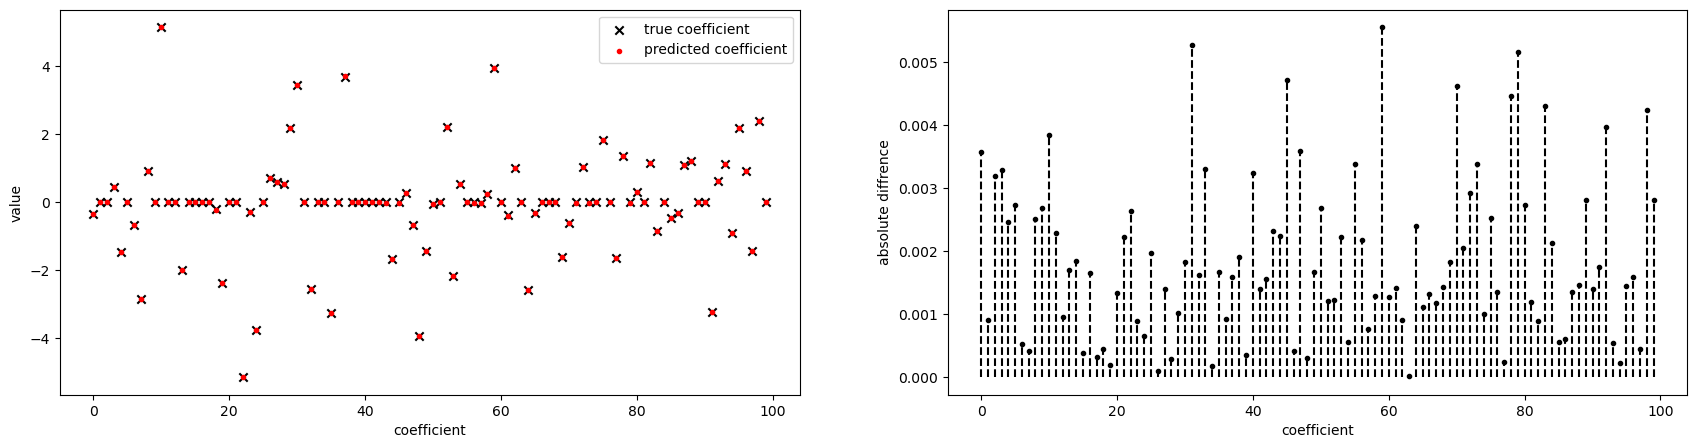

In [46]:
from matplotlib import collections as matcoll

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(21, 5))

ax_0.scatter(x=list(range(100)), y=beta, marker="x", c="k", label="true coefficient")
ax_0.scatter(x=list(range(100)), y=model_params['beta'].mean.detach().numpy(), marker=".", c="r", label="predicted coefficient")
ax_0.set_xlabel("coefficient")
ax_0.set_ylabel("value")
ax_0.legend()

y = np.abs(beta - model_params['beta'].mean.detach().numpy())
lines = []
for i in range(100):
    pair=[(i, 0), (i, y[i])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors="k", linestyle="--")
ax_1.add_collection(linecoll)

ax_1.scatter(x=list(range(100)), y=y, marker=".", c="k")
ax_1.set_xlabel("coefficient")
ax_1.set_ylabel("absolute diffrence")

plt.show()
plt.close()

In [13]:
def transform(array):
    a = array[:2]
    b = array[2:]
    return np.concatenate([a, np.exp(b)])

In [14]:
# Inspect posterior
print('True beta: {}'.format(beta))
print('True sigma: {}'.format(sigma))
print()

if advi_mode == "fullrank":
    beta_mean = transform(model_params['params'].mean.detach().numpy())
    beta_mean = np.array_str(beta_mean, precision=4, suppress_small=True)
    print('param mean: {}'.format(beta_mean))
    beta_std = model_params['params'].L.detach().numpy()
    beta_std = np.array_str(beta_std@beta_std.T, precision=4, suppress_small=True)
    print('param sd: \n{}'.format(beta_std))
elif advi_mode == "meanfield":
    beta_mean = model_params['beta'].mean.detach().numpy()
    print('beta mean: {}'.format(beta_mean))
    beta_std = model_params['beta'].log_s.exp().detach().numpy()
    beta_std = np.array_str(beta_std, precision=4, suppress_small=True)
    print('beta sd: {}'.format(beta_std))
    sig_mean = model_params['sig'].mean.exp().detach().numpy()
    print('sig mean: {}'.format(sig_mean))
    sig_std = model_params['sig'].log_s.exp().detach().numpy()
    print('sig std: {}'.format(sig_std))

True beta: tensor([-0.3301,  0.0000,  0.0000,  0.4544, -1.4577,  0.0000, -0.6620, -2.8476,
         0.9155,  0.0000,  5.1494,  0.0000,  0.0000, -1.9888,  0.0000,  0.0000,
         0.0000,  0.0000, -0.2078, -2.3674,  0.0000,  0.0000, -5.1409, -0.2901,
        -3.7635,  0.0000,  0.7288,  0.6079,  0.5534,  2.1956,  3.4449,  0.0000,
        -2.5576,  0.0000,  0.0000, -3.2508,  0.0000,  3.7033,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -1.6586,  0.0000,  0.2762, -0.6630,
        -3.9242, -1.4353, -0.0580,  0.0000,  2.2311, -2.1699,  0.5440,  0.0000,
         0.0000, -0.0158,  0.2535,  3.9485,  0.0000, -0.3834,  1.0139,  0.0000,
        -2.5856, -0.3132,  0.0000,  0.0000,  0.0000, -1.6180, -0.5915,  0.0000,
         1.0506,  0.0000,  0.0000,  1.8374,  0.0000, -1.6479,  1.3662,  0.0000,
         0.3191,  0.0000,  1.1696, -0.8329,  0.0000, -0.4496, -0.3164,  1.1009,
         1.2217,  0.0000,  0.0000, -3.2215,  0.6400,  1.1376, -0.8848,  2.1821,
         0.9363, -1.4187,  2.